In [11]:
!pip install --upgrade tables
!pip install eli5
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


## WCZYTYWANIE DANYCH


In [12]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car/"

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car


In [13]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [14]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## DUMMY MODEL

In [16]:
df.select_dtypes(np.number).columns #sprawdzenie która kolumna posiada wartości albo INT albo FLOAT

Index(['price_value', 'car_id'], dtype='object')

In [19]:
feats = ['car_id']
X = df[feats].values #lista cech dwa nawiasy kwadratowe
y = df['price_value'].values

model = DummyRegressor() #stworzenie modelu
model.fit(X,y) #trenowanie modelu
y_pred = model.predict(X) #prognozowanie

mae(y,y_pred) #mierzenie jakości (mean_absolute_error) - to ŚREDNIA róznica wartości ORYGINALNEJ minus wartości PROGNOZOWANEJ

39465.934630440985

In [21]:
[x for x in df.columns if 'price' in x] 

['price_currency', 'price_details', 'price_value']

In [25]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [26]:
df['price_currency'].value_counts(normalize=True) * 100 # w procentach

PLN    99.80844
EUR     0.19156
Name: price_currency, dtype: float64

In [27]:
df = df[ df['price_currency'] != 'RUR']
df.shape

(106494, 155)

## Features - preparation of features

In [30]:
for feat in df.columns:
  print (feat)


breadcrumb
created_at
price_currency
price_details
price_value
seller_address
seller_name
seller_type
feature_czujniki-parkowania-przednie
feature_poduszka-powietrzna-chroniąca-kolana
feature_kurtyny-powietrzne
feature_klimatyzacja-dwustrefowa
feature_światła-led
feature_czujnik-zmierzchu
feature_elektrycznie-ustawiane-lusterka
feature_asr-(kontrola-trakcji)
feature_poduszka-powietrzna-kierowcy
feature_cd
feature_elektryczne-szyby-przednie
feature_poduszka-powietrzna-pasażera
feature_system-start-stop
feature_światła-do-jazdy-dziennej
feature_komputer-pokładowy
feature_elektryczne-szyby-tylne
feature_klimatyzacja-manualna
feature_tapicerka-welurowa
feature_czujnik-deszczu
feature_światła-przeciwmgielne
feature_ogrzewanie-postojowe
feature_radio-niefabryczne
feature_regulowane-zawieszenie
feature_ogranicznik-prędkości
feature_zmieniarka-cd
feature_szyberdach
feature_isofix
feature_asystent-pasa-ruchu
feature_alufelgi
feature_bluetooth
feature_nawigacja-gps
feature_asystent-parkowania
fe

In [31]:
df['param_kolor'].factorize() # przypisanie w sposób indywidualny ID dla każdego koloru (factorize) - czyli bazujemy na liczbach a nie na stringach - model uczy się na liczbach ;)

(array([0, 1, 1, ..., 1, 3, 2]),
 Index(['Inny kolor', 'Czarny', 'Srebrny', 'Niebieski', 'Biały', 'Zielony',
        'Brązowy', 'Szary', 'Czerwony', 'Złoty', 'Bordowy', 'Beżowy', 'Żółty',
        'Fioletowy'],
       dtype='object'))

In [32]:
df['param_kolor'].factorize()[0] #wyciągniecie samych ID

array([0, 1, 1, ..., 1, 3, 2])

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0],list):continue

  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:
     df[feat + SUFFIX_CAT] = factorized_values

In [43]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x] 
cat_feats = [x for x in cat_feats if 'price' not in x] #wykluczamy kolumny ktore posiadaja CENY czyli liczby - wiec nie robimy faktoryzacji ID 
len(cat_feats)

151

In [46]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X , y , cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-19695.13091100928

## Nowy model do przetestowania które z cech (kolumny) są warte zainteresowania. Poprzednim model trenował na wszystkich cechach

In [50]:
NewModel = DecisionTreeRegressor(max_depth=5)
NewModel.fit(X,y)

imp = PermutationImportance(NewModel, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names = cat_feats)

Weight,Feature
0.2570 ± 0.0084,param_napęd__cat
0.2033 ± 0.0037,param_stan__cat
0.1957 ± 0.0021,param_faktura-vat__cat
0.1447 ± 0.0075,param_rok-produkcji__cat
0.0629 ± 0.0035,param_moc__cat
0.0415 ± 0.0012,feature_kamera-cofania__cat
0.0384 ± 0.0023,param_skrzynia-biegów__cat
0.0255 ± 0.0038,param_marka-pojazdu__cat
0.0196 ± 0.0014,param_pojemność-skokowa__cat
0.0162 ± 0.0003,feature_bluetooth__cat


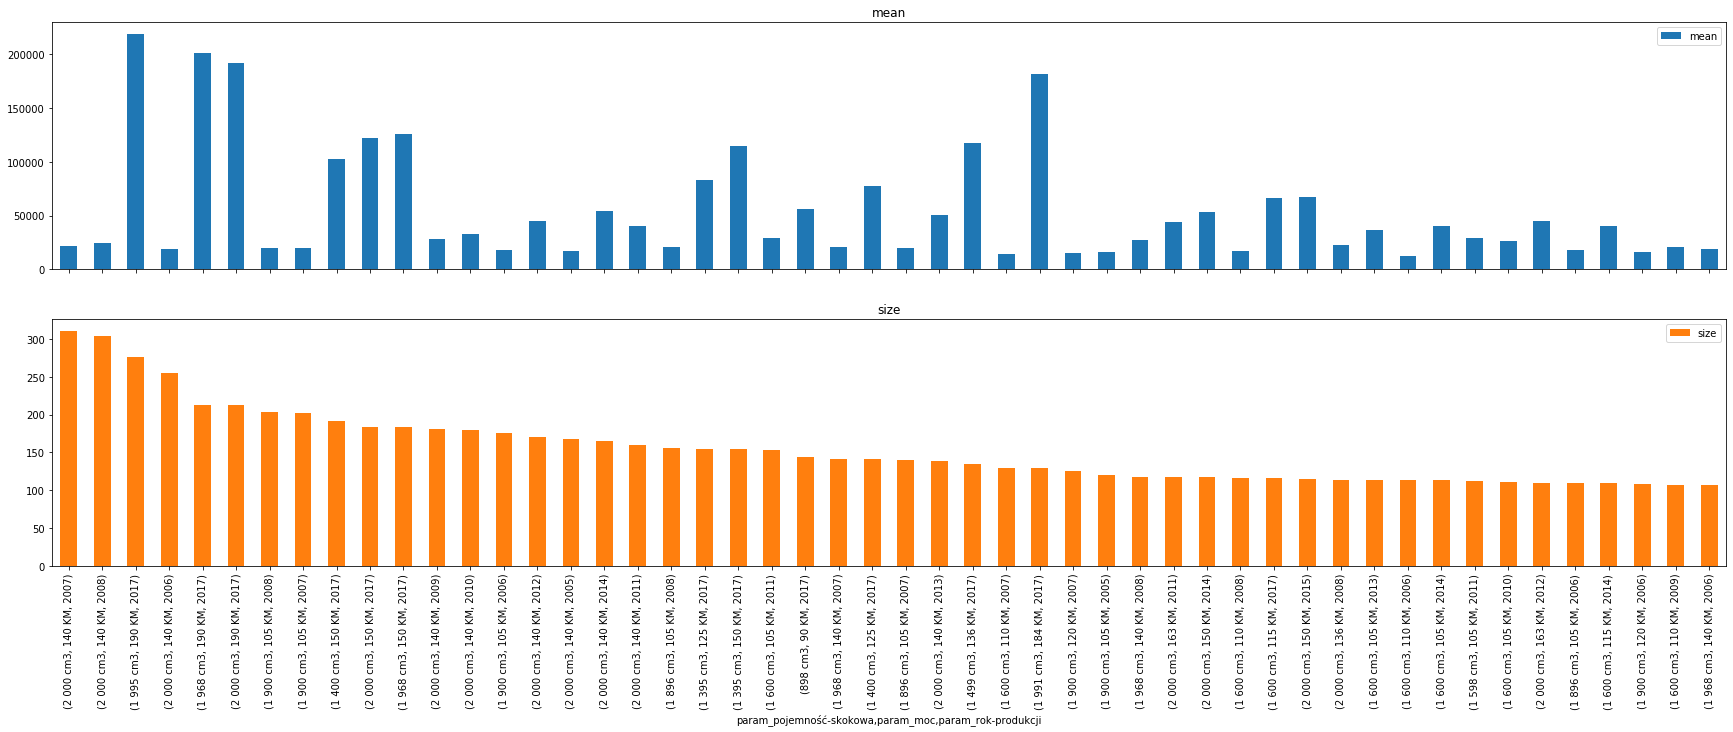

In [69]:
(
  df
    .groupby(['param_pojemność-skokowa','param_moc','param_rok-produkcji'])['price_value']
    .agg([np.mean,np.size])
    .sort_values(by='size',ascending=False)
    .head(50)
    .plot(kind='bar',figsize=(30,10),subplots=True)
    
);

##Model w oparciu o istotne cechy

In [150]:

newFeats = ['param_rok-produkcji__cat',
            'param_marka-pojazdu__cat',
            'param_model__cat',
            'param_pojemność-skokowa__cat',
            'param_napęd__cat',
            'param_skrzynia-biegów__cat',
            'param_moc__cat',
            'param_uszkodzony__cat',
            'param_model__cat',
            'param_rodzaj-paliwa__cat',
                      
            ] # 18467

X = df[newFeats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X , y , cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-18465.49117783274